In [101]:
%load_ext autoreload
import glob
import nibabel
import pandas as pd
import numpy as np

from collections import defaultdict, Counter
from matplotlib import pyplot as plt
from tqdm import tqdm_notebook, tqdm
from joblib import Parallel, delayed

from IPython.core.debugger import set_trace

import os
import shutil
import argparse
import time
import json
import pickle

import torch
from torch import nn
from torch import autograd
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from models.v2v import V2VModel

import yaml
from easydict import EasyDict as edict

from utils import check_patch, pad_arrays, create_dicts, normalize, load, video

from multiprocessing import cpu_count
N_CPU = cpu_count()

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split

import cc3d

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important}</style>"))

from celluloid import Camera

SEED = 42
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
roc_auc_score()

In [102]:
seg = nibabel.load('../fcd_data/normalized_segmentation/9.nii').get_fdata()

In [104]:
plt.ioff()
camera = video(seg,
              n_slides=128)
animation = camera.animate() # animation ready
HTML(animation.to_html5_video()) # displaying the animation

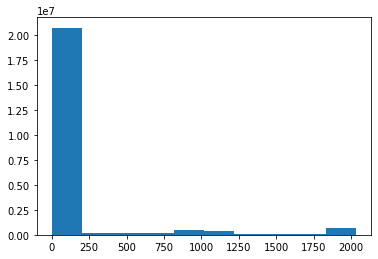

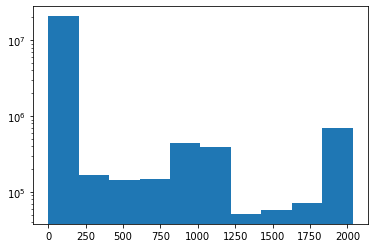

In [111]:
plt.ioff()
plt.figure()
plt.hist(seg.flatten())
plt.yscale('log')
plt.show()

In [69]:
labels_components = np.load('labels_info.npy', allow_pickle=True).item()
single_component_keys = {k for k,v in labels_components.items() if len(v['cc3d'][0]) == 2}

In [70]:
len(single_component_keys)

87

In [71]:
USE_GEOM_FEATURES = True
GEOM_FEATURES = ['thickness', 'sulc', 'curv']

root_label = '../fcd_data/normalized_label'
root_data = '../fcd_data/normalized_data/'
root_geom_features = '../fcd_data/preprocessed_data_anadezhda/'

paths_dict = create_dicts(root_label,
                         root_data,
                         root_geom_features, 
                         single_component_keys,
                         USE_GEOM_FEATURES, 
                         GEOM_FEATURES)

In [76]:
len(paths_dict)

77

In [77]:
def make_tensor(root, label, pdict, USE_GEOM_FEATURES):
    
    brain_tensor, mask_tensor, label_tensor = load(pdict)
    
    ################
    # MAKE TENSORS #
    ################
    
    label_tensor_torch = torch.tensor(label_tensor, dtype=torch.float32)
    mask_tensor_torch = torch.tensor(mask_tensor, dtype=torch.long)
    brain_tensor_torch = torch.tensor(brain_tensor, dtype=torch.float32)
    
    mask = mask_tensor_torch.type(torch.bool)
    brain_tensor_torch[mask] = normalized(brain_tensor_torch[mask])
    brain_tensor_torch[~mask] = 0
    
    torch_tensor = {'brain':brain_tensor_torch, 
                      'mask':mask_tensor_torch,
                      'label':label_tensor_torch}
    
    if USE_GEOM_FEATURES:
        GEOM_FEATURES = list(set(pdict.keys()) - {'label', 'brain', 'mask'})
        feature_tensors = [nibabel.load(pdict[f'{feature_name}']).get_fdata() \
                           for feature_name in GEOM_FEATURES]
        
        for i, feature_name in enumerate(GEOM_FEATURES):
            feature_tensor = torch.tensor(feature_tensors[i], dtype=torch.float)
            feature_tensor[mask] = normalized(feature_tensor[mask])
            feature_tensor[~mask] = 0
            
            torch_tensor[feature_name] = feature_tensor
        
    torch.save(torch_tensor, os.path.join(root, f'tensor_{label}'))

# _ = Parallel(n_jobs=-1)(delayed(make_tensor)('../fcd_data/normalized_tensors', k, v, USE_GEOM_FEATURES) for k,v in tqdm(paths_dict.items()))

In [80]:
tensor = torch.load('../fcd_data/normalized_tensors/tensor_1')

In [10]:
for k,v in tensor.items():
    print(k, v.max(), v.min(), v.shape)

brain tensor(1.) tensor(0.) torch.Size([241, 336, 283])
mask tensor(1) tensor(0) torch.Size([241, 336, 283])
label tensor(1.) tensor(0.) torch.Size([241, 336, 283])
sulc tensor(1.) tensor(0.) torch.Size([241, 336, 283])
thickness tensor(1.) tensor(0.) torch.Size([241, 336, 283])
curv tensor(1.) tensor(0.) torch.Size([241, 336, 283])


# Metadata

In [21]:
metadata_root = './metadata'
train_keys, test_keys = train_test_split(list(paths_dict.keys()), test_size=0.1, random_state=SEED)
metadata = {'train':train_keys,
            'test':test_keys,
            'seed':SEED}

np.save(metadata_root, metadata)

In [22]:
metadata = np.load('metadata.npy',allow_pickle=True).item()

# Yarkin data (draft)

In [14]:
# root = '../fcd_data/yarkin_06dec2021'

In [16]:
# ls -la ../fcd_data/yarkin_06dec2021/sub-9/ # sub-17_MNI152NLint2_brain-Flair.nii

total 1175352
drwxr-xr-x  2 ibulygin users      4096 дек  6 15:33 ./
drwxrwxrwx 92 ibulygin users      4096 дек  6 15:47 ../
-rw-r--r--  1 ibulygin users 183330016 дек  6 15:33 c1sub-9_MNI152NLint2_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c1sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c2sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  45613408 дек  6 15:33 c3sub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users  91226464 дек  6 15:33 hrsub-9_brain-Flair_mask.nii
-rw-r--r--  1 ibulygin users    256056 дек  6 15:33 hrsub-9_brain-Flair_mask.nii.gz
-rw-r--r--  1 ibulygin users 182452576 дек  6 15:33 hrsub-9_brain-Flair.nii
-rw-r--r--  1 ibulygin users  21892116 дек  6 15:33 hrsub-9_brain-Flair.nii.gz
-rw-r--r--  1 ibulygin users 182452576 дек  6 15:33 msub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users   2371932 дек  6 15:33 norm_and_wgsub-9_struct-Flair.nii
-rw-r--r--  1 ibulygin users   2371932 дек  6 15:33 skullstriped-sub-9_s

c1sub-9_MNI152NLint2_struct-Flair.nii - **asym**  
c1sub-9_struct-Flair.nii - **SYM!**  
c2sub-9_struct-Flair.nii - **SYM!**  
c3sub-9_struct-Flair.nii - **SYM!**  
hrsub-9_brain-Flair_mask.nii - **SYM!**  
hrsub-9_brain-Flair_mask.nii.gz - **SYM!**  
hrsub-9_brain-Flair.nii - **checK IT!! SYM!**  
hrsub-9_brain-Flair.nii.gz - **SYM!**  
msub-9_struct-Flair.nii - **SYM!, tissue**  
norm_and_wgsub-9_struct-Flair.nii - **SYM, lowdim**  
skullstriped-sub-9_struct-Flair.nii - **SYM, lowdim**  
sub-9_MNI152NLint2_brain-Flair.nii - **BRAIN, 1X1, ASYM**    
sub-9_struct-Flair.nii - **ASYM**  
sub-9_struct-Flair_seg_inv_sn.mat  
sub-9_struct-Flair_seg_sn.mat  
wc1_or_wc2sub-9_struct-Flair.nii - **SYM lowdim**  
wc1sub-9_struct-Flair.nii - **SYM lowdim**  
wc2sub-9_struct-Flair.nii - **SYM lowdim**    
wc3sub-9_struct-Flair.nii - **SYM lowdim**    
wmsub-9_struct-Flair.nii - **SYM lowdim tissues**   

In [82]:
# brain = nibabel.load('../fcd_data/yarkin_06dec2021/sub-9/sub-9_MNI152NLint2_brain-Flair.nii').get_fdata()
# brain = nibabel.load('../fcd_data/yarkin_06dec2021/sub-9/hrsub-9_brain-Flair.nii').get_fdata()